In [39]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = [12, 8]

In [40]:
# Generated signal parameters
t_end = 4 # s
f_s = 1000000 # Hz
f_c = 172000000 # Hz
f_t = 5000 # Hz offset from center
t_ping = 0.05 # s
ping_period = 1 # s
ping_power = -96 # dB
noise_power = -60 # dB

In [41]:
# Computed signal parameters
ping_amplitude = 10 ** (ping_power / 20) # FS
ping_length = int(t_ping * f_s) # samples
ping_time_index = np.arange(0, ping_length)
ping_signal = np.cos(f_t / 2 * np.pi* ping_time_index) + 1j * np.sin(f_t / 2 * np.pi* ping_time_index)

ping_period_samples = ping_period * f_s
noise_snr = 10.0**(noise_power/10.0)
ping_wait_signal = np.random.normal(0, np.sqrt(noise_snr*2.0)/2.0, size=(int((ping_period - t_ping) * f_s), 2)).view(np.complex) # Generate noise with calculated power
ping_signal_noise = ping_amplitude * ping_signal + np.random.normal(0, np.sqrt(noise_snr*2.0)/2.0, size=(len(ping_signal), 2)).view(np.complex).reshape(len(ping_signal)) # Generate noise with calculated power

signal = np.array([0.00001])
golden_ping_idx = []
for i in range(int(t_end / ping_period)):
    signal = np.append(signal, ping_signal_noise)
    golden_ping_idx.append(len(signal))
    signal = np.append(signal, ping_wait_signal)
signal = np.append(signal, ping_signal_noise)

np.array(golden_ping_idx) / f_s

array([0.050001, 1.050001, 2.050001, 3.050001])

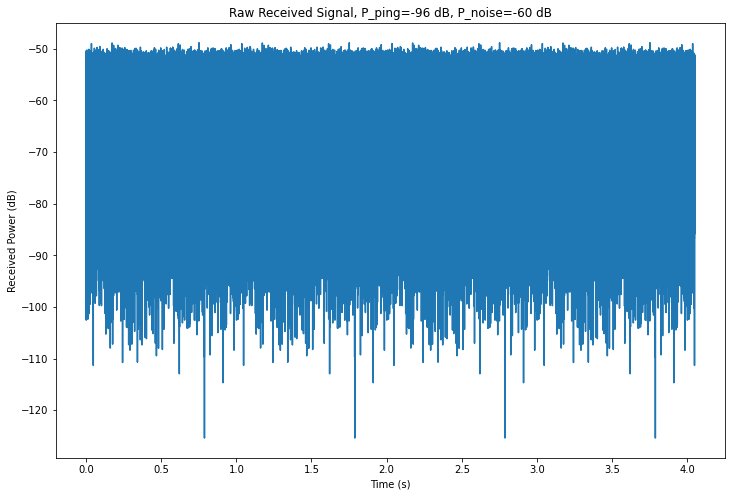

In [42]:
signal_magnitude = np.abs(signal)
signal_power = 20 * np.log10(signal_magnitude)
t = np.arange(len(signal_power)) / f_s
plt.plot(t, signal_power)
plt.title("Raw Received Signal, P_ping=%d dB, P_noise=%d dB" % (ping_power, noise_power))
plt.xlabel("Time (s)")
plt.ylabel("Received Power (dB)")
plt.savefig("raw_signal.png")

In [43]:
# autocorrelation parameters
AC_window_len = 0.001 # s
lag = 0.001 # s

In [44]:
AC_window_len_s = 2048
template = np.flip(ping_signal[:AC_window_len_s])
AC_f_s = f_s / 1024

# AC_signal = np.correlate(template, signal, mode='valid')
AC_signal = np.zeros(int(len(signal) / 1024), dtype=complex)
for i in range(int((len(signal) - AC_window_len_s) / 1024)):
#     AC_signal[i] = np.max(np.correlate(ping_signal[0:0 + AC_window_len_s], signal[i + lag_s:i + lag_s + AC_window_len_s], "same"))
    AC_signal[i] = np.sum(np.multiply(template, signal[i * 1024 : i * 1024 + AC_window_len_s]))

/home/ntlhui/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


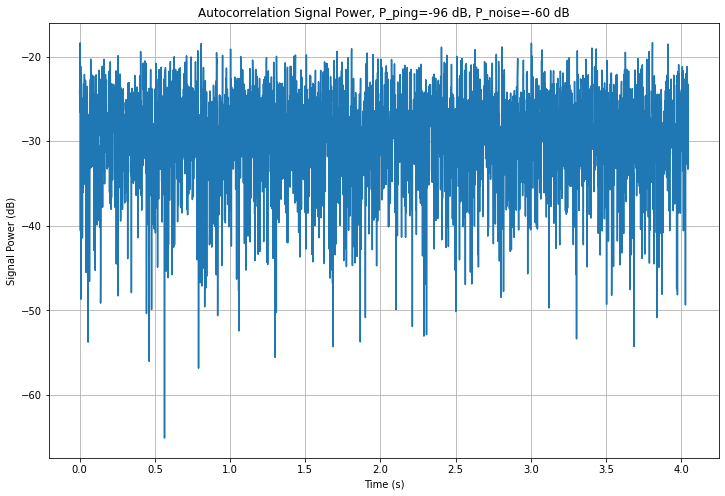

In [45]:
AC_signal_magnitude = np.abs(AC_signal)
AC_signal_power = 20 * np.log10(AC_signal_magnitude)
t = np.arange(len(AC_signal_power)) / AC_f_s

plt.plot(t, AC_signal_power)
plt.ylabel("Signal Power (dB)")
plt.xlabel("Time (s)")
plt.title("Autocorrelation Signal Power, P_ping=%d dB, P_noise=%d dB" % (ping_power, noise_power))
plt.grid()
plt.savefig('ac_freq.png')

Note: AC_signal needs to be scaled down by the length of the template to measure the actual received signal power

In [46]:
ping_len_AC_s = int(t_ping * AC_f_s)
ping_q_len_AC_s = int((ping_period - t_ping) * AC_f_s)
ping_template_AC = np.concatenate((np.ones(ping_len_AC_s, dtype=complex), np.ones(ping_q_len_AC_s, dtype=complex) * 1e-9))

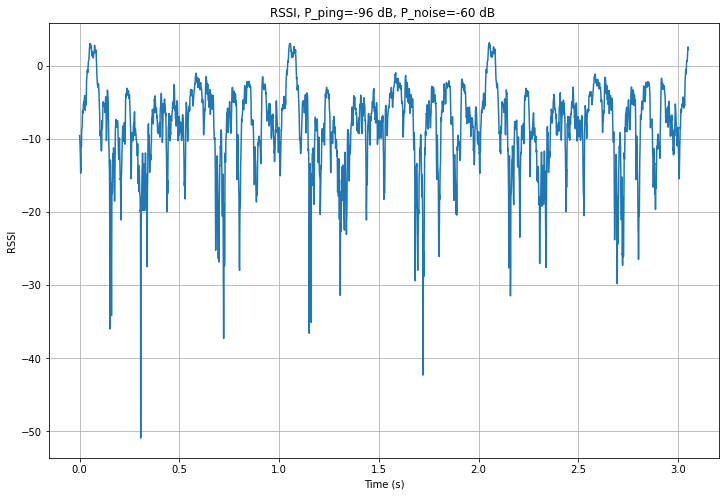

In [47]:
ping_ideal = np.convolve(ping_template_AC, AC_signal, mode='valid')
ping_rssi = 20 * np.log10(np.abs(ping_ideal))
t = np.arange(len(ping_rssi)) / AC_f_s

plt.plot(t, ping_rssi)
plt.ylabel("RSSI")
plt.xlabel("Time (s)")
plt.title("RSSI, P_ping=%d dB, P_noise=%d dB " % (ping_power, noise_power))
plt.grid()
plt.savefig('ac_ping.png')

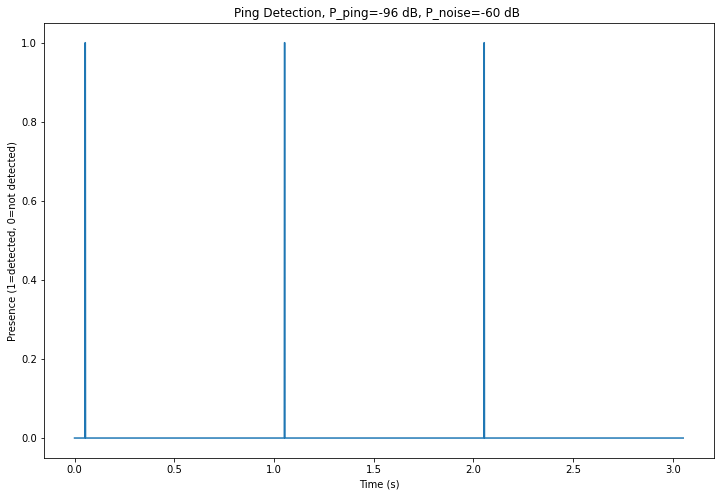

In [48]:
ping_locator = ping_rssi > 3
t = np.arange(len(ping_locator)) / AC_f_s

plt.plot(t, ping_locator)
plt.ylabel("Presence (1=detected, 0=not detected)")
plt.xlabel("Time (s)")
plt.title("Ping Detection, P_ping=%d dB, P_noise=%d dB " % (ping_power, noise_power))
plt.savefig("ping_presence.png")

In [49]:
ping_t = []
for i in range(len(ping_locator) - 1):
    if ping_locator[i] == 0 and ping_locator[i + 1] == 1:
        ping_t.append((i + 1) / AC_f_s)
print("Pings at %s" % ping_t)

Pings at [0.053248, 1.052672, 2.05312]
